## Линейная регрессия

Рассмотрим первую простую модель линейной регрессии, которая выглядит так:
$$y = \sum_{i=1}^{n} w_ix_i + b,$$
где $x_i$ - входы модели, $y$ - выход, $w_i$ и $b$ - параметры модели, которые мы будем обучать.

Для одномерного случая формула выглядит следующим образом:
$$y = wx+b$$

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.stats import norm
from copy import copy

sns.set_style("dark")

Для начала сгенерируем данные, по которым попытаемся восстановить зависимость. Возьмем простую функцию $$f(x) = 5x+4$$, вычислим несколько значений для 100 равноотстоящих значений $x$ от -5 до 5 и добавим шума. Можно сразу заметить, что оптимальными значениями $w$ и $b$ будут числа 5 и 4 соответственно, но, предположим, мы этого не знаем.

In [59]:
def drawData(X,Y):
    plt.plot(X, Y, 'o')
    plt.title("data points")
    plt.xlabel('x',color='#1C2833')
    plt.ylabel('y',color='#1C2833')
    plt.show()


def drawLine(X, Y, w):
    predicted = np.dot(X, w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, '-r',linewidth=4)
    plt.title('fitted line')
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.show()


def generatePointsOnLine():
    X = np.linspace(-5,5,100)
    np.random.shuffle(X)
    Y = 5*copy(X)+4
    return X, Y


def addNoise(Y):
    Y += norm.rvs(size=Y.shape[0])
    return Y


def generateDataset(draw=False):
    X, Y = generatePointsOnLine()
    Y = addNoise(Y)
    if draw:
        drawData(X,Y)
    return X,Y

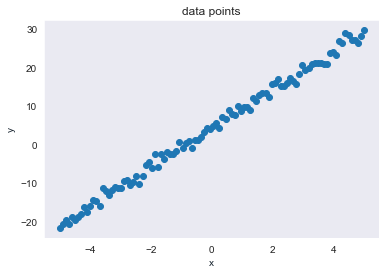

In [60]:
X, Y = generateDataset(draw=True)

Перед обучением необходимо сделать две вещи. Во-первых, разобъем наши данные на 2 выборки: тренировочную и тестовую. На тренировочной выборке будем обучать модель, а на тестовой проверять способность обобщения.

Во-вторых, применим небольшой трюк: к вектору x приклеим вектор из единиц, получим матрицу
$$\left( \begin{matrix}
x_0 & 1\\
x_1 & 1\\
... & ... \\
x_{99} & 1
\end{matrix} \right).$$

Такой прием необходим, чтобы можно было легко использовать матричные умножения, зашитые внутри языка программирования. Умножив такую матрицу на вектор$\{w, b\}$, получим ту же самую формулу $wx+b$. Использование матричных умножений предпочтительнее просто потому, что в данном виде вычисления производятся гораздо быстрее из-за использования низкоуровневых языков, на которых написаны библиотеки Python. Данный прием называется *векторизация*.

In [61]:
def trainTestSplit(X,Y):
    X = X.reshape(X.shape[0],1)
    Y = Y.reshape(Y.shape[0],1)
    X = np.hstack((X,np.ones((X.shape[0],1))))
    train_size = int(X.shape[0] * 0.8)
    X_train = X[0:train_size,:]
    Y_train = Y[0:train_size,:]
    X_test = X[train_size:,:]
    Y_test = Y[train_size:,:]
    return X, X_train,Y_train,X_test,Y_test

In [62]:
X, X_train, Y_train, X_test, Y_test = trainTestSplit(X,Y)

## Точная формула

Для линейной регрессии существует точная формула, возволяющая найти все коэфициэнты:
$$w=(X^TX)^*X^TY,$$
где * означает псевдоинверсию.

In [63]:
def computePseudoInverse(X,Y):
    w = np.dot(np.dot(np.linalg.inv((np.dot(X.T,X))), X.T),Y)
    return w


def computeTestError(X_test, Y_test, w):
    return np.mean(np.square(np.dot(X_test, w) - Y_test))

Test error:  1.0270953391421505
[[5.01580455]
 [4.17299001]]


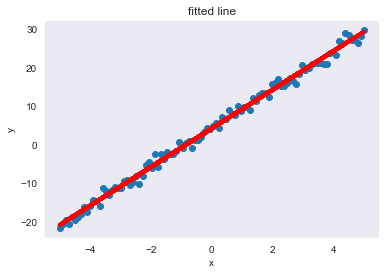

In [64]:
w = computePseudoInverse(X_train, Y_train)
print("Test error: ", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

## Градиентнтый спуск

В случае больших размерностей данных точная формула будет вычисляться слишком долго, поэтому в таких случаях используют приближенные методы. Рассмотрим один из наиболее популярных: *градиентный спуск*. 

In [65]:
def gradient_descent(X, Y, w, lr=1e-3, steps=10**3, print_times=20):
    history = np.zeros(steps)
    w_history = np.zeros((steps, w.shape[0], 1))
    i = 0
    print_epochs = steps//print_times
    
    for epoch in range(steps):
        # Вычисление градиентна
        error = -2*(Y - np.dot(X, w))
        grad = np.mean(error*X, axis=0)
        
        b = grad[-1]
        grad = grad[:len(grad)-1]
        grad = grad / np.linalg.norm(grad)
        grad = np.hstack((grad, b))
        grad.resize((X.shape[1], 1))
        # Обновление весов
        w = w - lr * grad
        
        if epoch % print_epochs == 0:
            print('.', end='')
            
        history[i] = computeTestError(X, Y, w)
        w_history[i] = w
        i+=1

    return w, history, w_history

Test error: 872.6469024872365
[[ 15]
 [-15]]


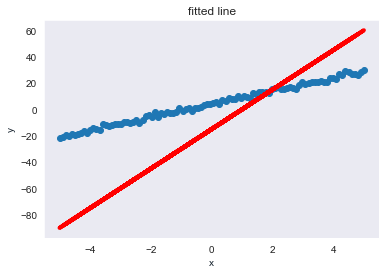

In [66]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([15, -15]).reshape((X_train.shape[1], 1))

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

....................Test error: 1.018661976831805
[[5.        ]
 [4.17770794]]


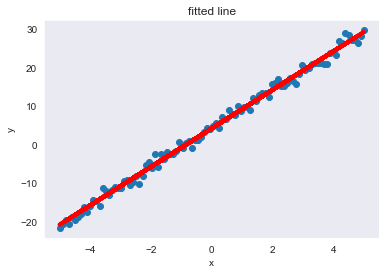

In [67]:
w, history, w_history = gradient_descent(X_train, Y_train, w, lr=1e-1)

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

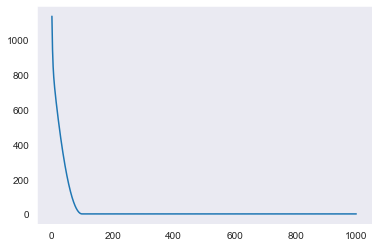

In [68]:
plt.plot(history)

In [69]:
w_grid, b_grid = np.mgrid[-20:20,
                -20:20]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

История обновления весов

In [70]:
w_history.resize((w_history.shape[0], 2))

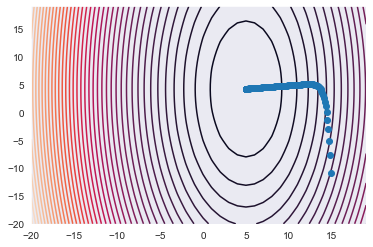

In [71]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=50)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

#### Слишком большой learning rate

....................Test error: 137.1338448377991


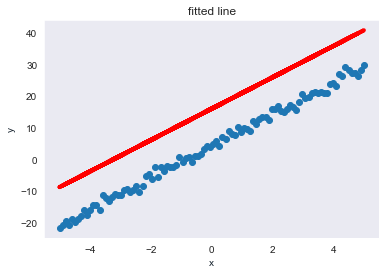

In [72]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([-5, 0]).reshape((X_train.shape[1], 1))

w, history, w_history = gradient_descent(X_train, Y_train, w, lr=0.995)

print("Test error:", computeTestError(X_test, Y_test, w))
drawLine(X, Y, w)

In [73]:
w_history.resize((w_history.shape[0], 2))

In [74]:
w_grid, b_grid = np.mgrid[-20:20,
                -20:20]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

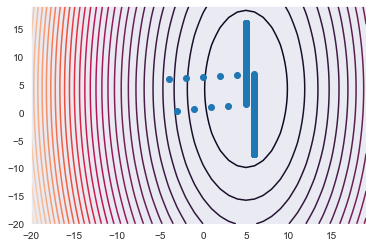

In [75]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=30)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

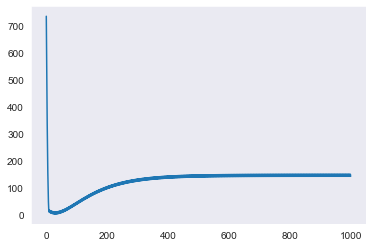

In [76]:
plt.plot(history[:])

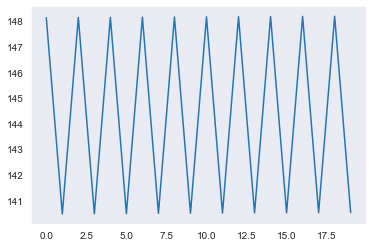

In [77]:
plt.plot(history[700:720])

#### Слишком маленький learning rate

....................Test error: 212.3908322156724
[[-0.5       ]
 [ 2.94434827]]


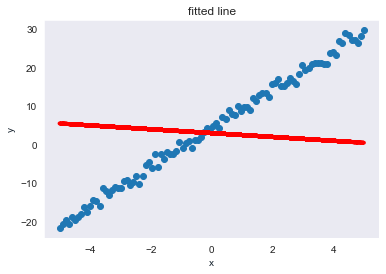

In [78]:
#w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))
w = np.array([-1, 2]).reshape((X_train.shape[1], 1))

w, history, w_history = gradient_descent(X_train, Y_train, w, lr=5*1e-4)

print("Test error:", computeTestError(X_test, Y_test, w))
print(w)
drawLine(X, Y, w)

In [79]:
w_history.resize((w_history.shape[0], 2))

In [80]:
w_grid, b_grid = np.mgrid[-10:10,
                -10:10]
error = np.zeros((w_grid.shape[0], w_grid.shape[1]))
for i in range(w_grid.shape[0]):
    for j in range(w_grid.shape[1]):
        error[i][j] = np.mean(np.square(Y - (np.dot(X, [w_grid[i][j], b_grid[i][j]]))))

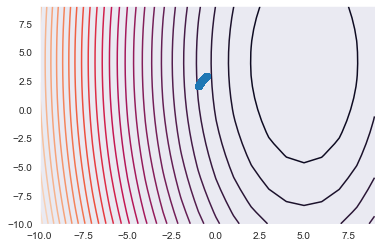

In [81]:
fig, ax = plt.subplots()

ax.contour(w_grid, b_grid, error, levels=30)
ax.plot(w_history[:, 0], w_history[:, 1], 'o')

plt.show()

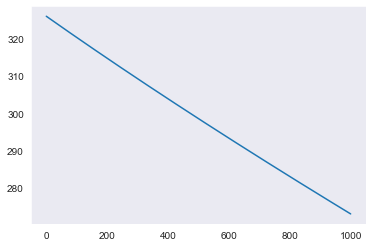

In [82]:
plt.plot(history)

## Многочлен

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.stats import norm
import seaborn as sns

sns.set_style("dark")

In [17]:
def drawData(X,Y):
    plt.plot(X,Y,'o')
    plt.title("data points")
    plt.xlabel('x',color='#1C2833')
    plt.ylabel('y',color='#1C2833')
    plt.show()


def drawPolynom(X,Y,w, X_m=[], Y_m=[]):
    predicted = np.dot(X,w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, 'o',linewidth=1)
    plt.plot(X_m, Y_m, '--')
    plt.title('fitted line')
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.show()


def addNoise(Y):
    Y += norm.rvs(size=Y.shape[0])
    return Y


def generatePointsOnLine(shuffle=True, n=100):
    X = np.linspace(-3,3,n)
    if shuffle:
        np.random.shuffle(X)
    Y = 2*np.sin(X)
    return X,Y


def generateDataset():
    X,Y = generatePointsOnLine()
    Y = addNoise(Y)
    drawData(X,Y)
    return X,Y

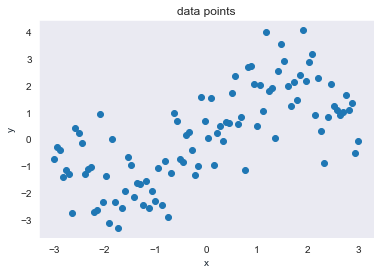

In [18]:
X_gen, Y = generateDataset()

In [19]:
def addFeatures(X, p):
    for i in range(1,p+1):
        X = np.hstack((X,(X[:,0].reshape((X[:,0].shape[0],1)))**(i + 1)))

    X = np.hstack((X,np.ones((X.shape[0],1))))
    return X


def trainTestSplit(X,Y, p=4):
    X = X.reshape(X.shape[0],1)
    Y = Y.reshape(Y.shape[0],1)
    X = addFeatures(X, p)
    train_size = int(X.shape[0] * 0.8)
    X_train = X[0:train_size,:]
    Y_train = Y[0:train_size,:]
    X_test = X[train_size:,:]
    Y_test = Y[train_size:,:]
    return X, X_train,Y_train,X_test,Y_test

In [20]:
X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y,4)
X_m, Y_m = generatePointsOnLine(shuffle=False)

In [21]:
def computePseudoInverse(X,Y):
    w = np.dot(np.dot(linalg.inv((np.dot(X.T,X))), X.T),Y)
    return w


def computeTestError(X_test, Y_test, w):
    return np.mean(np.abs(np.dot(X_test, w) - Y_test))

Test error:  0.622361044243659


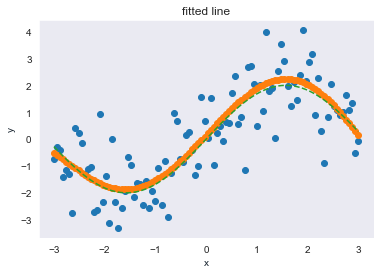

In [22]:
w = computePseudoInverse(X_train, Y_train)
print("Test error: ", computeTestError(X_test, Y_test, w))
drawPolynom(X, Y, w, X_m, Y_m)

Попробуем посмотреть, как будет вести себя аналитическое решение для разных степеней.

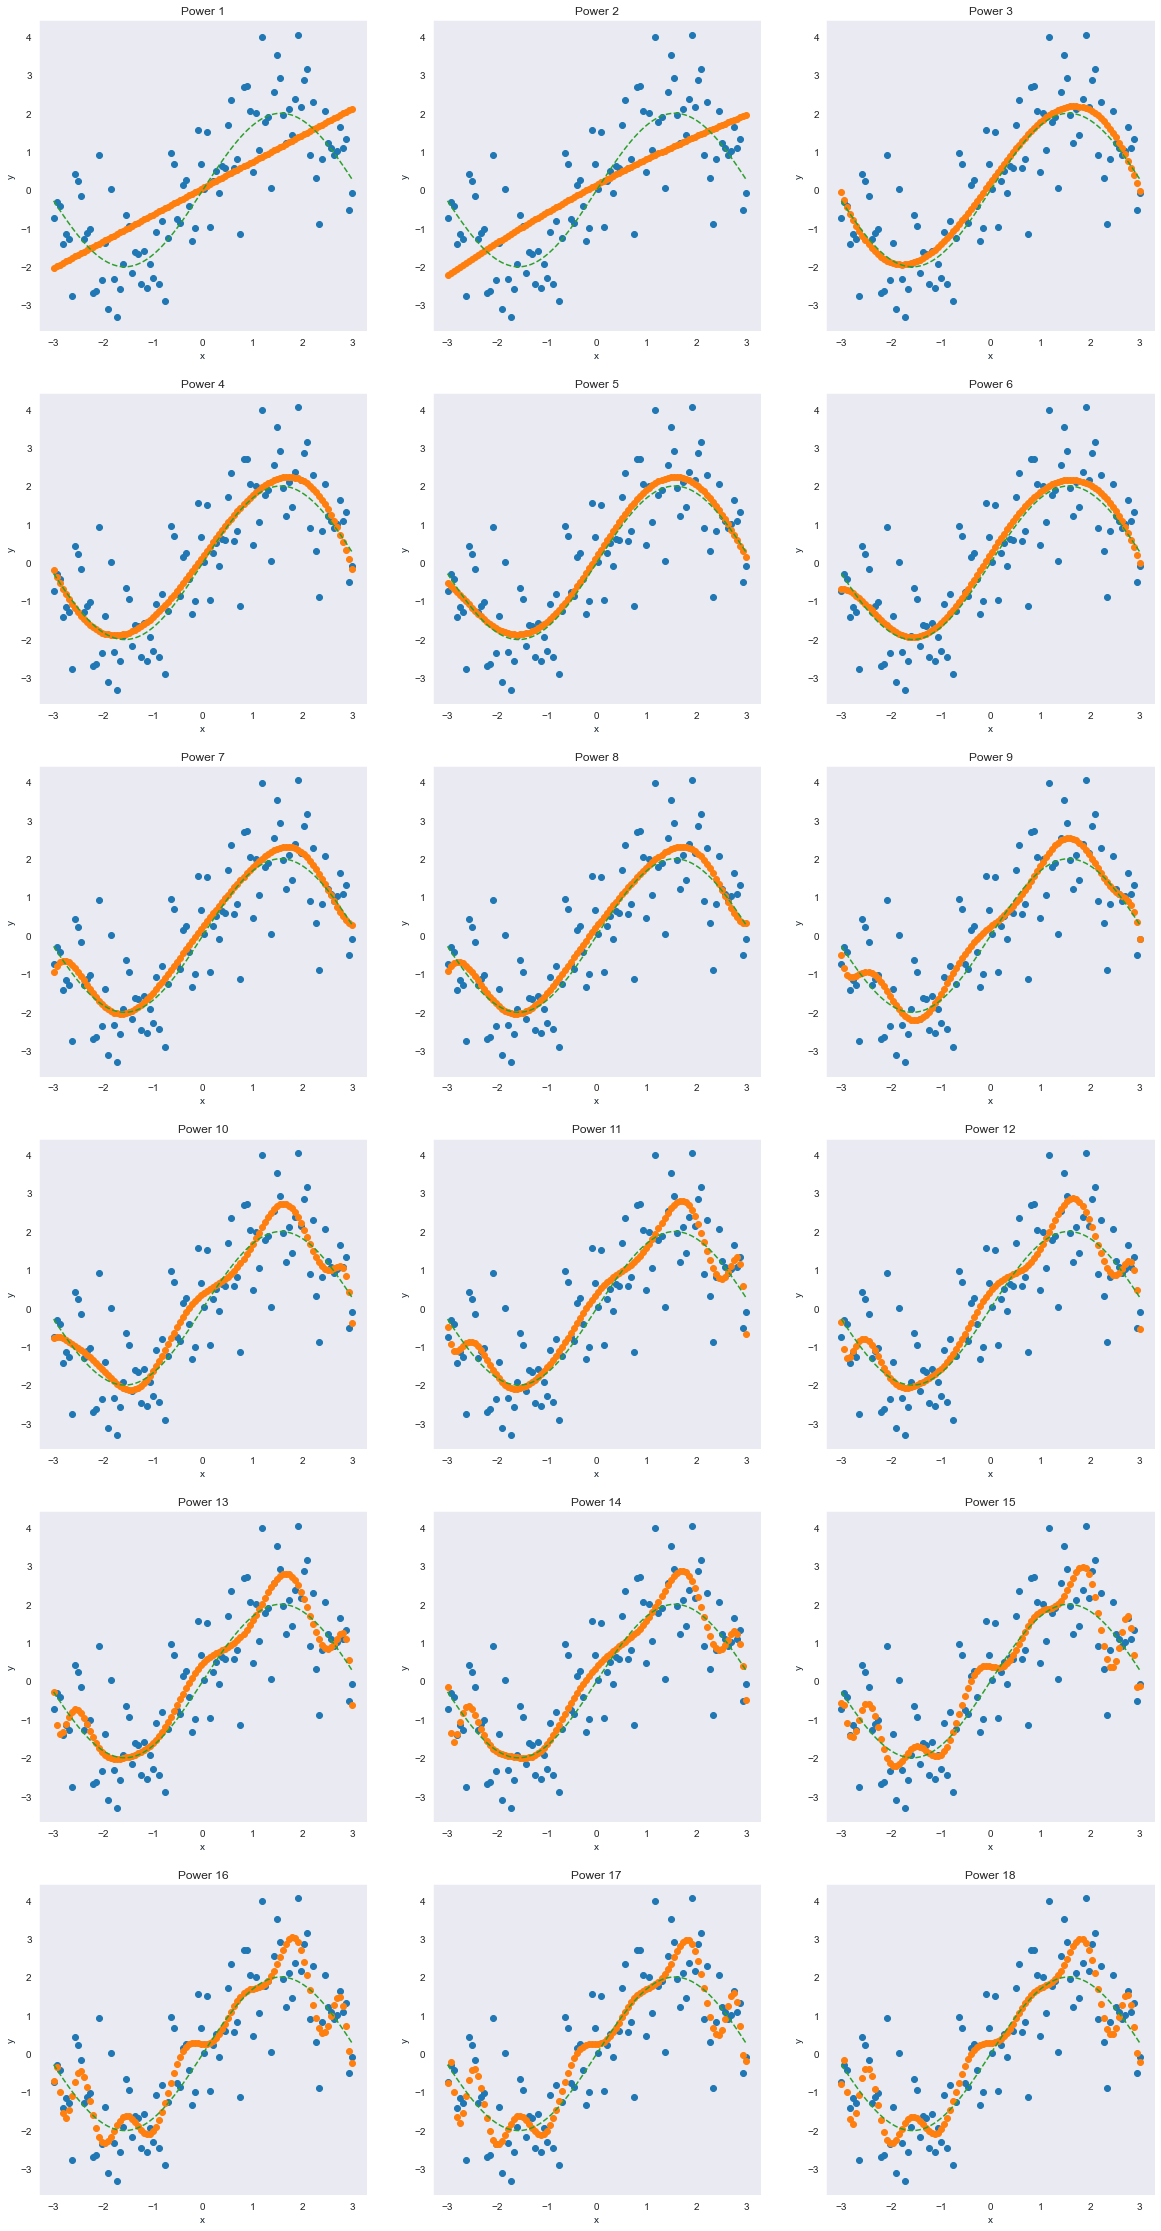

In [24]:
plt.figure(figsize=(20,40))
test_err = np.zeros(18)
train_err = np.zeros(18)
for p in range(18):
    X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y, p)
    w = computePseudoInverse(X_train, Y_train)
    train_err[p] = computeTestError(X_train, Y_train, w)
    test_err[p] = computeTestError(X_test, Y_test, w)
    
    plt.subplot(6,3,p+1)
    plt.grid(False)
    predicted = np.dot(X, w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X[:,0], predicted, 'o',linewidth=1)
    plt.plot(X_m, Y_m, '--')
    plt.title("Power "+str(p+1))
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
plt.show()

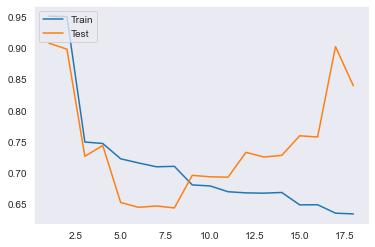

In [91]:
plt.plot(range(1, 19), train_err, label='train_error')
plt.plot(range(1, 19), test_err, label='test_error')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Как видно, при низких степенях модель ожидаемо не может обучиться, а с их увеличение сначала точность растет, а потом падает. Мы можем сделать вывод, что чрезмерное увеличение сложности модели ведет к переобучению.

Иногда невозможно использовать точную формулу по ряду причин: размерности могут быть слишком большими, а для схожих моделей аналитического решения попросту не существует. Поэтому приходится прибегать к градиентному спуску. Ещё один нюанс, который следует держать в уме: вычислительная мощность модель обычно берется чуть больше, чем необходимо, потому что оптимальное значение неизвестно.

### Градиентный спуск

Test error: 281.63213402896514


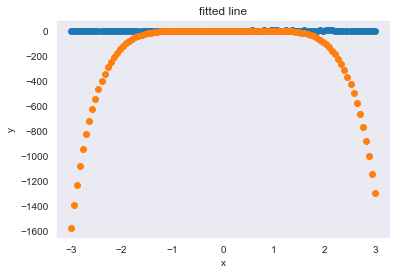

In [92]:
X, X_train,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y, 5)
w = norm.rvs(scale=1, size=X_train.shape[1]).reshape((X_train.shape[1], 1))

print("Test error:", computeTestError(X_test, Y_test, w))
drawPolynom(X, Y, w)

....................
....................
....................
Test error: 0.6613150478634775


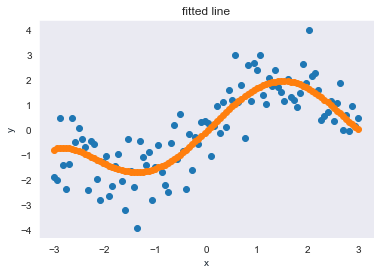

In [93]:
for lr in [1e-3, 1e-4/5, 1e-4]:
    w, _, _ = gradient_descent(X_train, Y_train, w, steps=10**5, lr=lr)
    print()  
    
print("Test error:", computeTestError(X_test, Y_test, w))
drawPolynom(X, Y, w)

### Уменьшение количества данных

In [26]:
def trainTestSplit(X,Y, p=4):
    X = X.reshape(X.shape[0],1)
    Y = Y.reshape(Y.shape[0],1)
    X = addFeatures(X, p)
    train_size = int(X.shape[0] * 0.2)
    X_train = X[0:train_size,:]
    Y_train = Y[0:train_size,:]
    X_test = X[train_size:,:]
    Y_test = Y[train_size:,:]
    return X, X_train,Y_train, X_test,Y_test

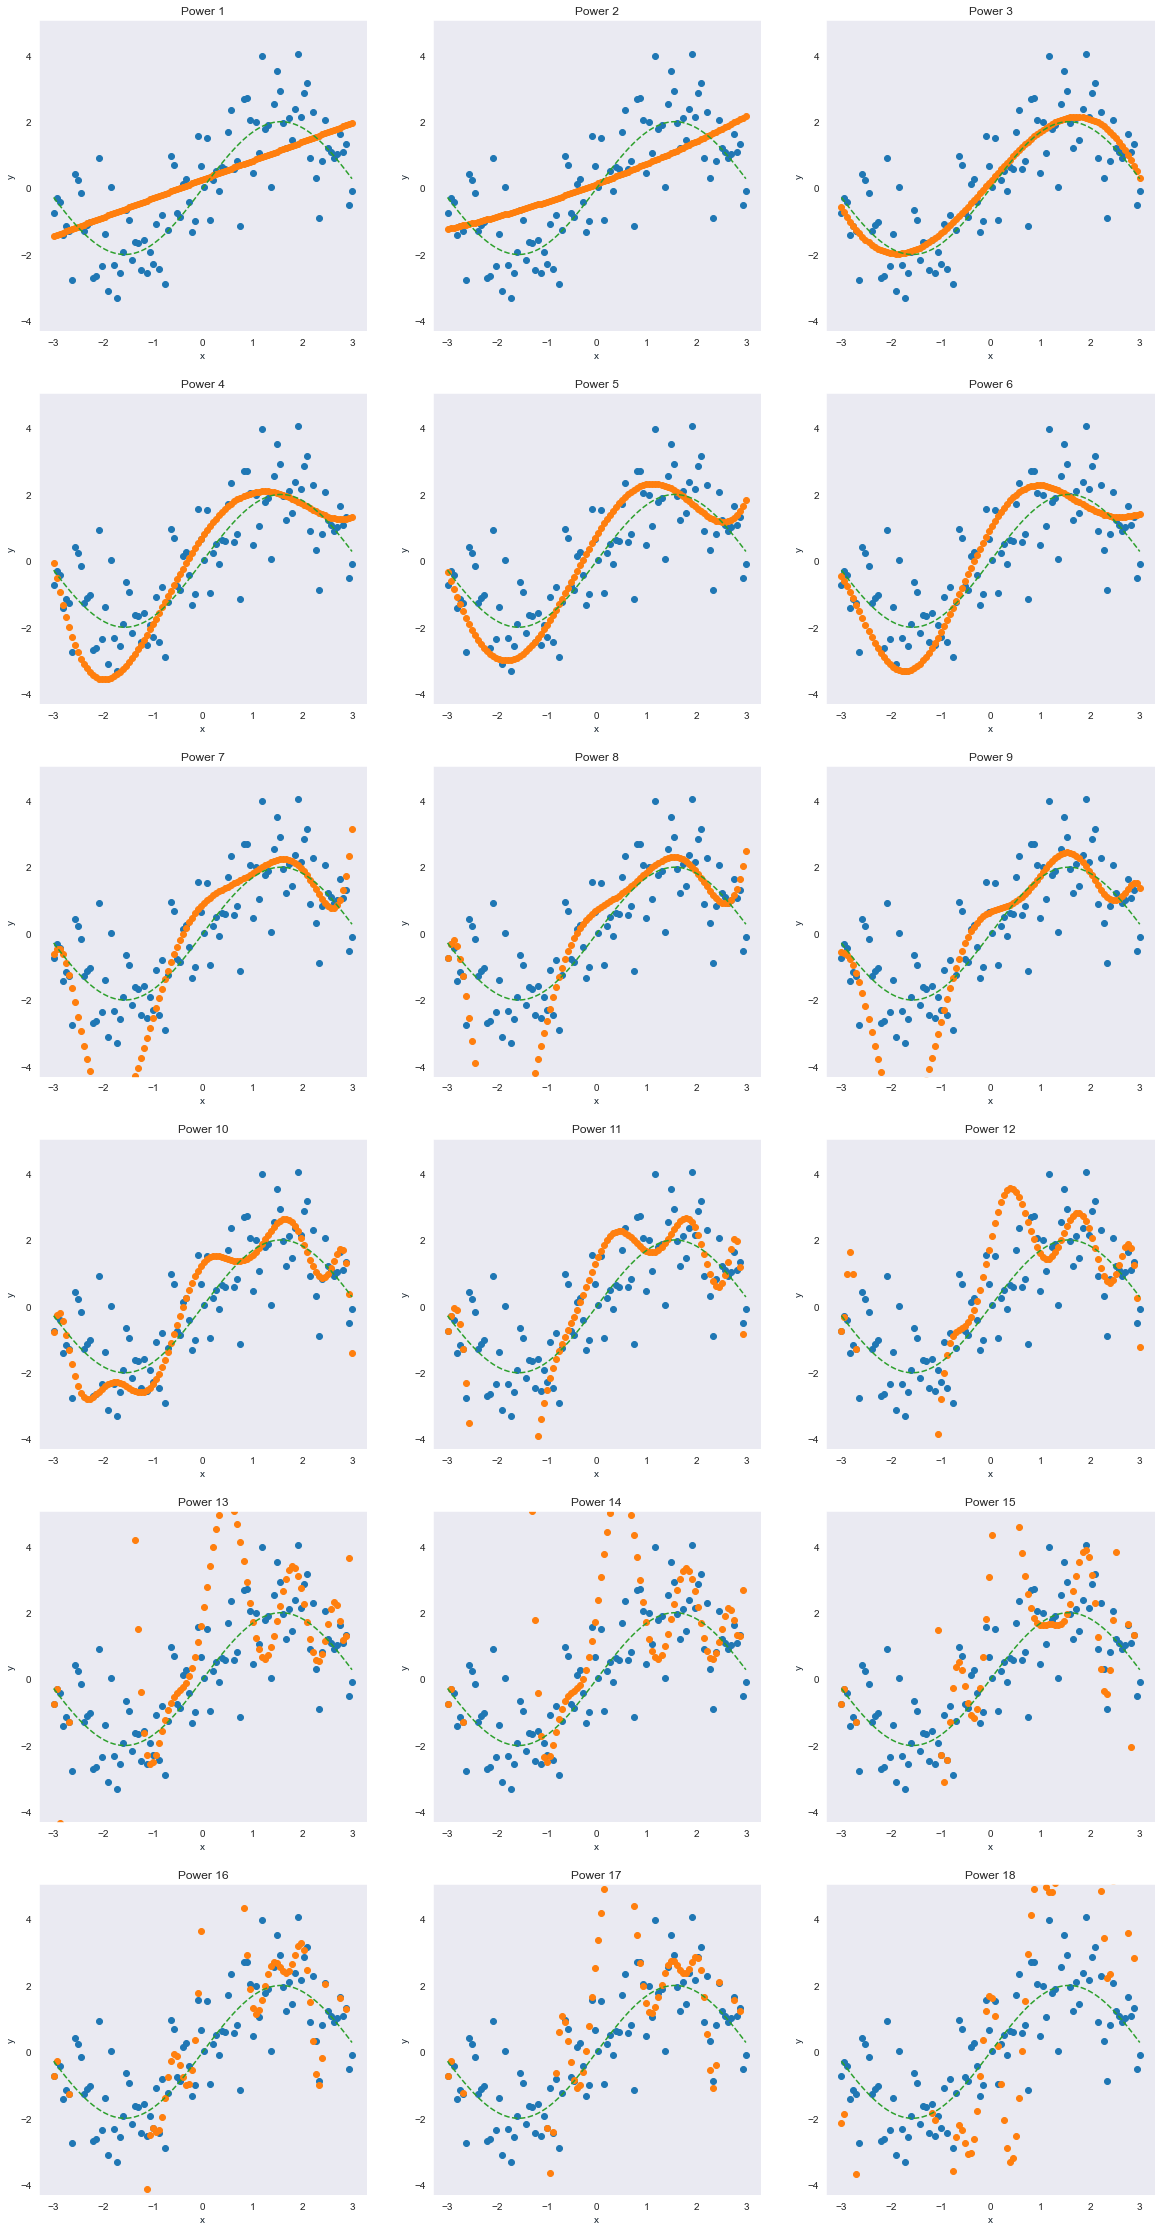

In [43]:
plt.figure(figsize=(20,40))
test_err = np.zeros(18)
train_err = np.zeros(18)
w_list = []
for p in range(18):
    X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y, p)
    w = computePseudoInverse(X_train, Y_train)
    w_list.append(w)
    train_err[p] = computeTestError(X_train, Y_train, w)
    test_err[p] = computeTestError(X_test, Y_test, w)
    
    X_w = np.linspace(-3,3,100)
    X_w = X_w.reshape(X_w.shape[0],1)
    X_w = addFeatures(X_w, p)
    
    plt.subplot(6,3,p+1)
    plt.grid(False)
    axes = plt.gca()
    axes.set_ylim([min(Y)-1,max(Y)+1])
    predicted = np.dot(X_w, w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X_w[:,0], predicted, 'o',linewidth=1)
    plt.plot(X_m, Y_m, '--')
    plt.title("Power "+str(p+1))
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
plt.show()

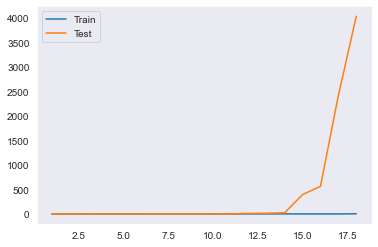

In [30]:
plt.plot(range(1, 19), train_err, label='train_error')
plt.plot(range(1, 19), test_err, label='test_error')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

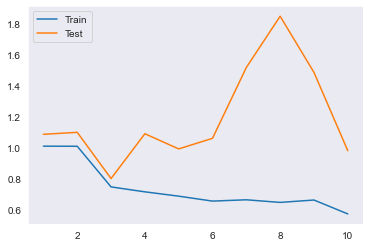

In [31]:
plt.plot(range(1, 11), train_err[:10], label='train_error')
plt.plot(range(1, 11), test_err[:10], label='test_error')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

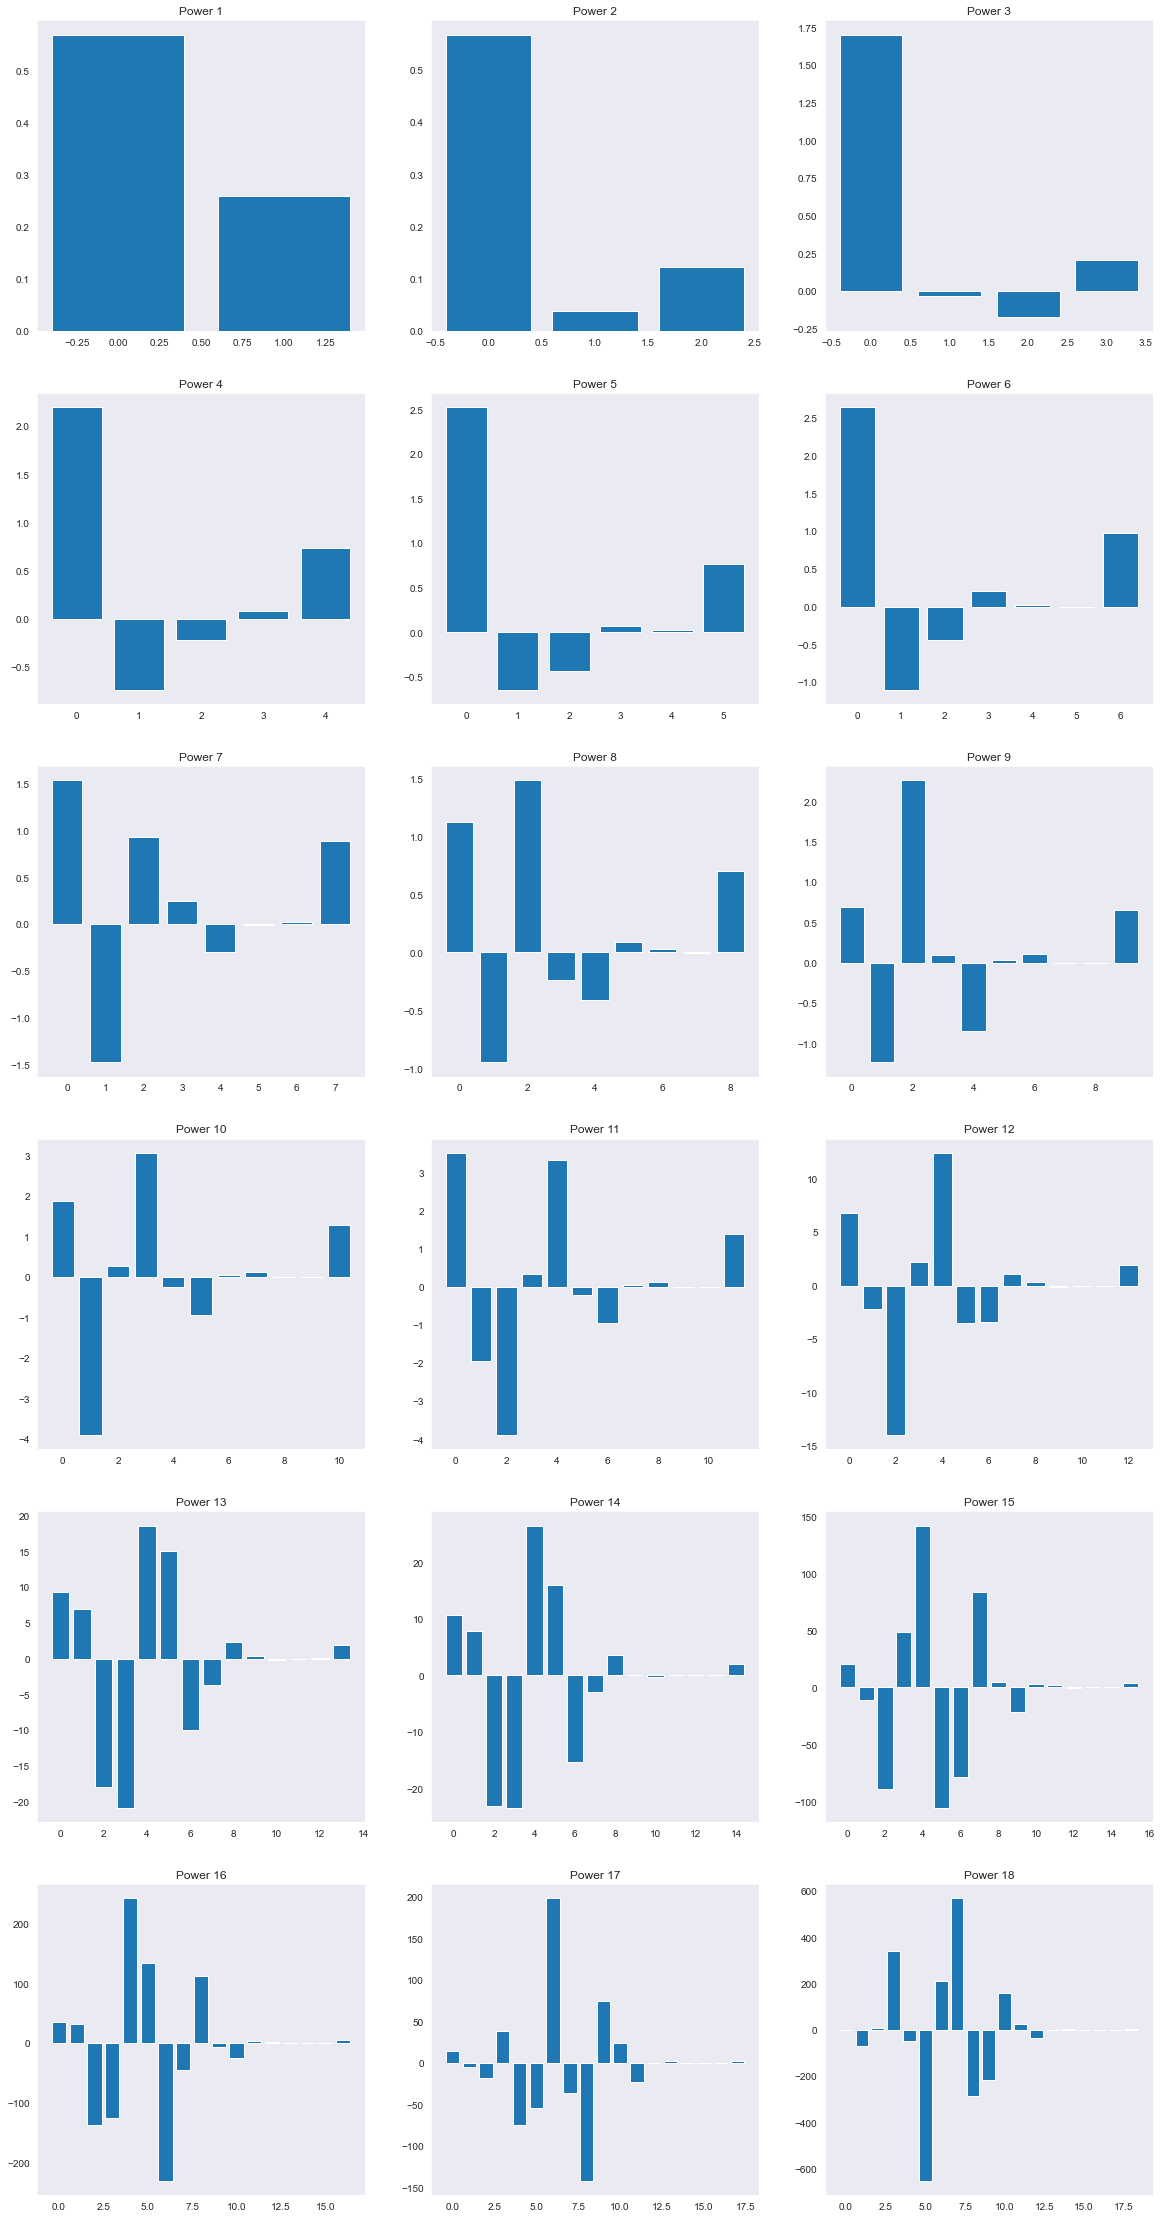

In [32]:
plt.figure(figsize=(20,40))
for p, w in enumerate(w_list):
    w = w.reshape(w.shape[0])
    
    plt.subplot(6,3,p+1)
    plt.bar(range(len(w)), w)
    plt.title("Power "+str(p+1))
plt.show()

### Регуляризация

$\Large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} = 0 &\Leftrightarrow& -X^T \vec{y} + X^T X \vec{w} + \lambda \vec{w} = 0 \\ &\Leftrightarrow& X^T X \vec{w} + \lambda \vec{w} = X^T \vec{y} \\ &\Leftrightarrow& \left(X^T X + \lambda E\right) \vec{w} = X^T \vec{y} \\ &\Leftrightarrow& \vec{w} = \left(X^T X + \lambda E\right)^{-1} X^T \vec{y} \end{array}$

In [33]:
def computePseudoInverseRegularization(X,Y, lmbd):
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbd*np.eye(X.shape[1])), X.T), Y)
    return w

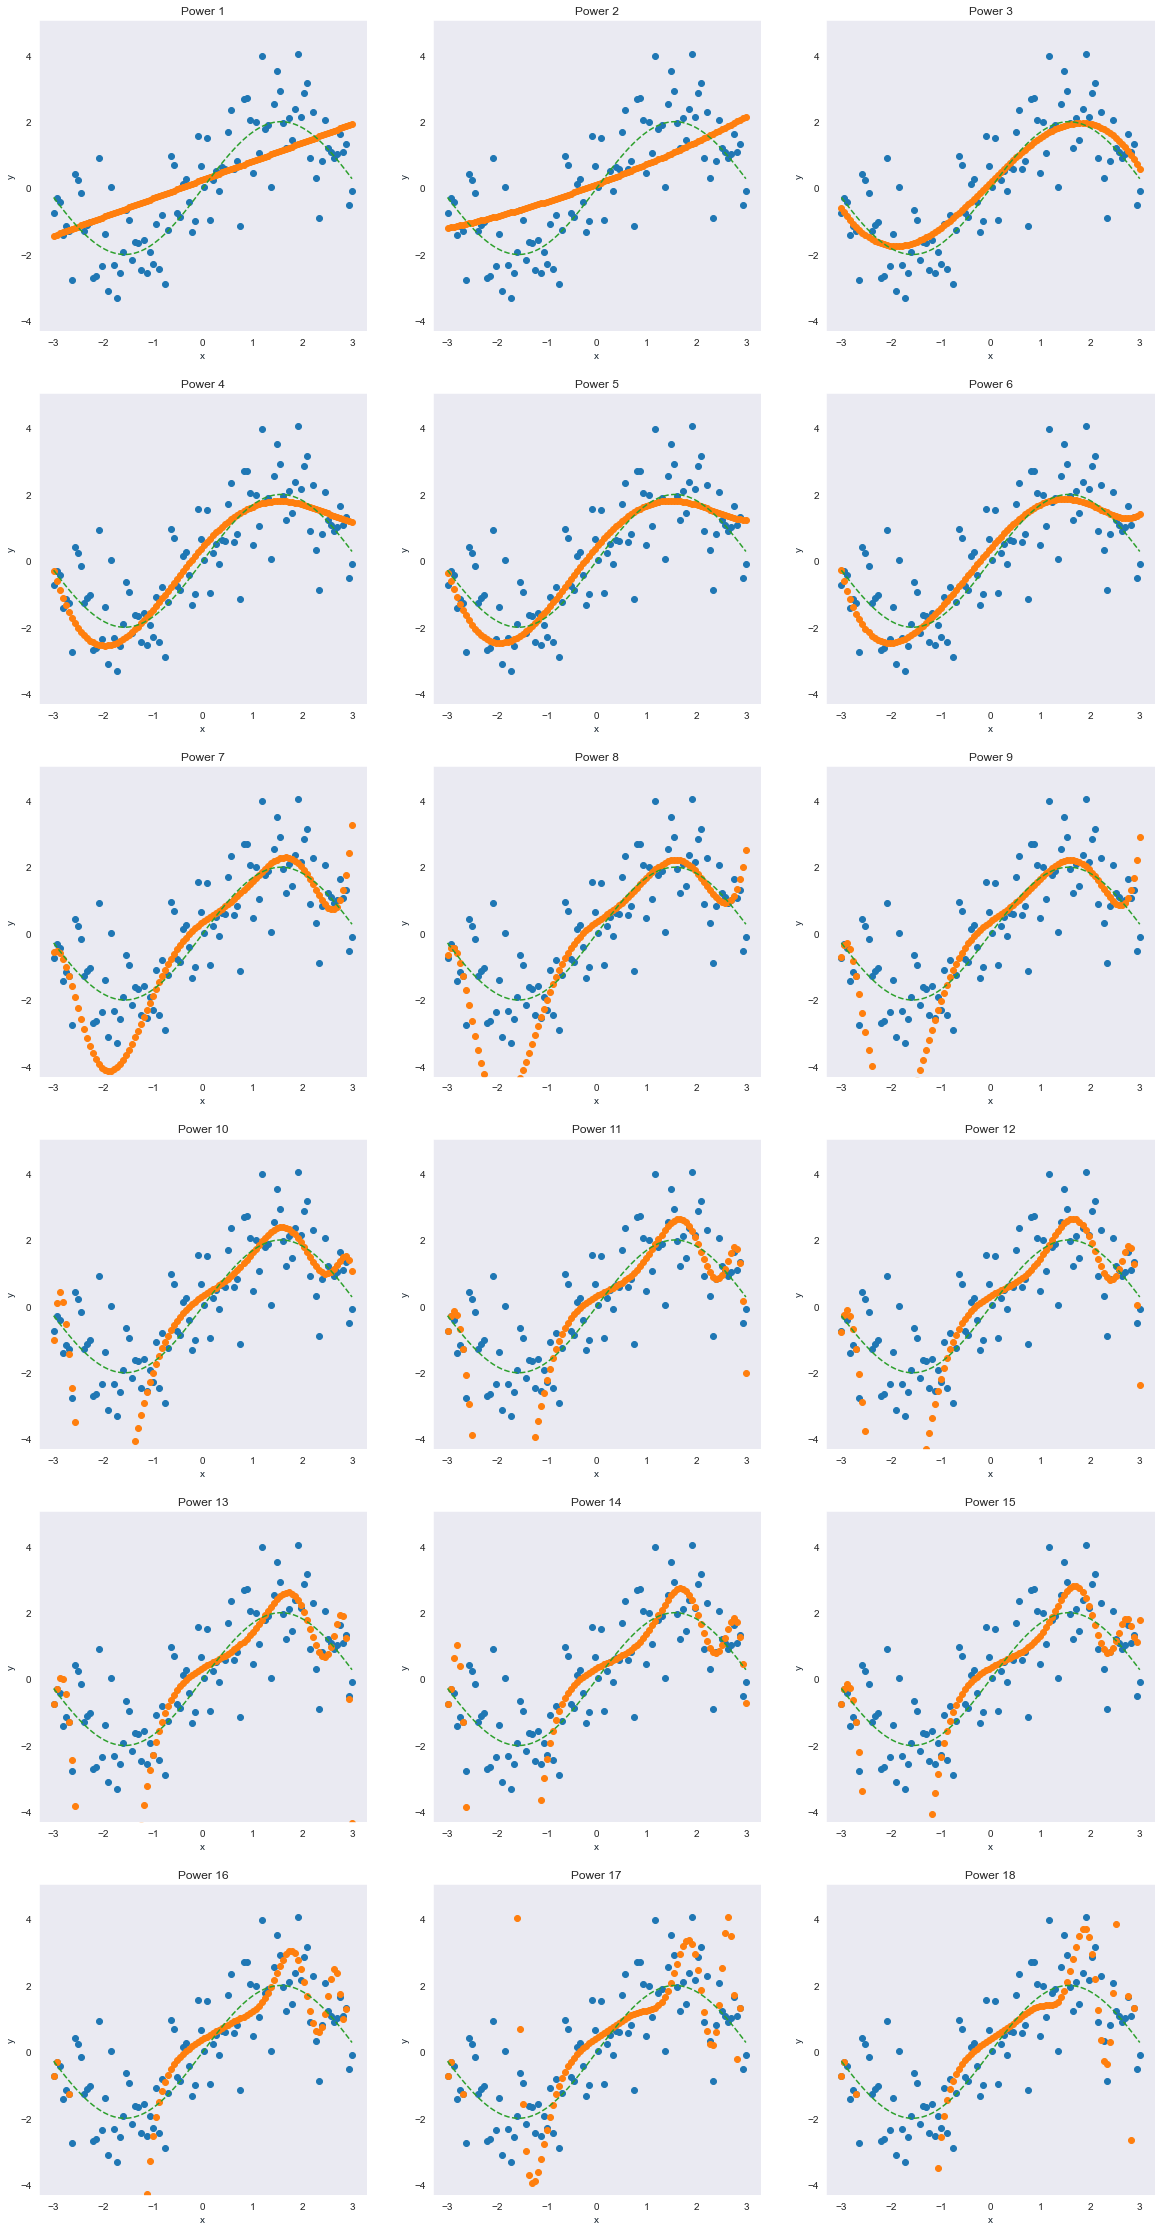

In [42]:
lmbd = 1

plt.figure(figsize=(20,40))
test_err = np.zeros(18)
train_err = np.zeros(18)
w_list = []
for p in range(18):
    X, X_train ,Y_train, X_test, Y_test = trainTestSplit(X_gen, Y, p)
    w = computePseudoInverseRegularization(X_train, Y_train, lmbd)
    w_list.append(w)
    train_err[p] = computeTestError(X_train, Y_train, w)
    test_err[p] = computeTestError(X_test, Y_test, w)
    
    X_w = np.linspace(-3,3,100)
    X_w = X_w.reshape(X_w.shape[0],1)
    X_w = addFeatures(X_w, p)
    
    plt.subplot(6,3,p+1)
    plt.grid(False)
    axes = plt.gca()
    axes.set_ylim([min(Y)-1,max(Y)+1])
    predicted = np.dot(X_w, w)
    plt.plot(X[:,0],Y,'o')
    plt.plot(X_w[:,0], predicted, 'o',linewidth=1)
    plt.plot(X_m, Y_m, '--')
    plt.title("Power "+str(p+1))
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
plt.show()

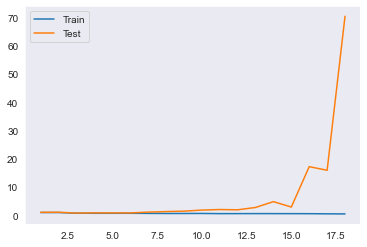

In [39]:
plt.plot(range(1, 19), train_err, label='train_error')
plt.plot(range(1, 19), test_err, label='test_error')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

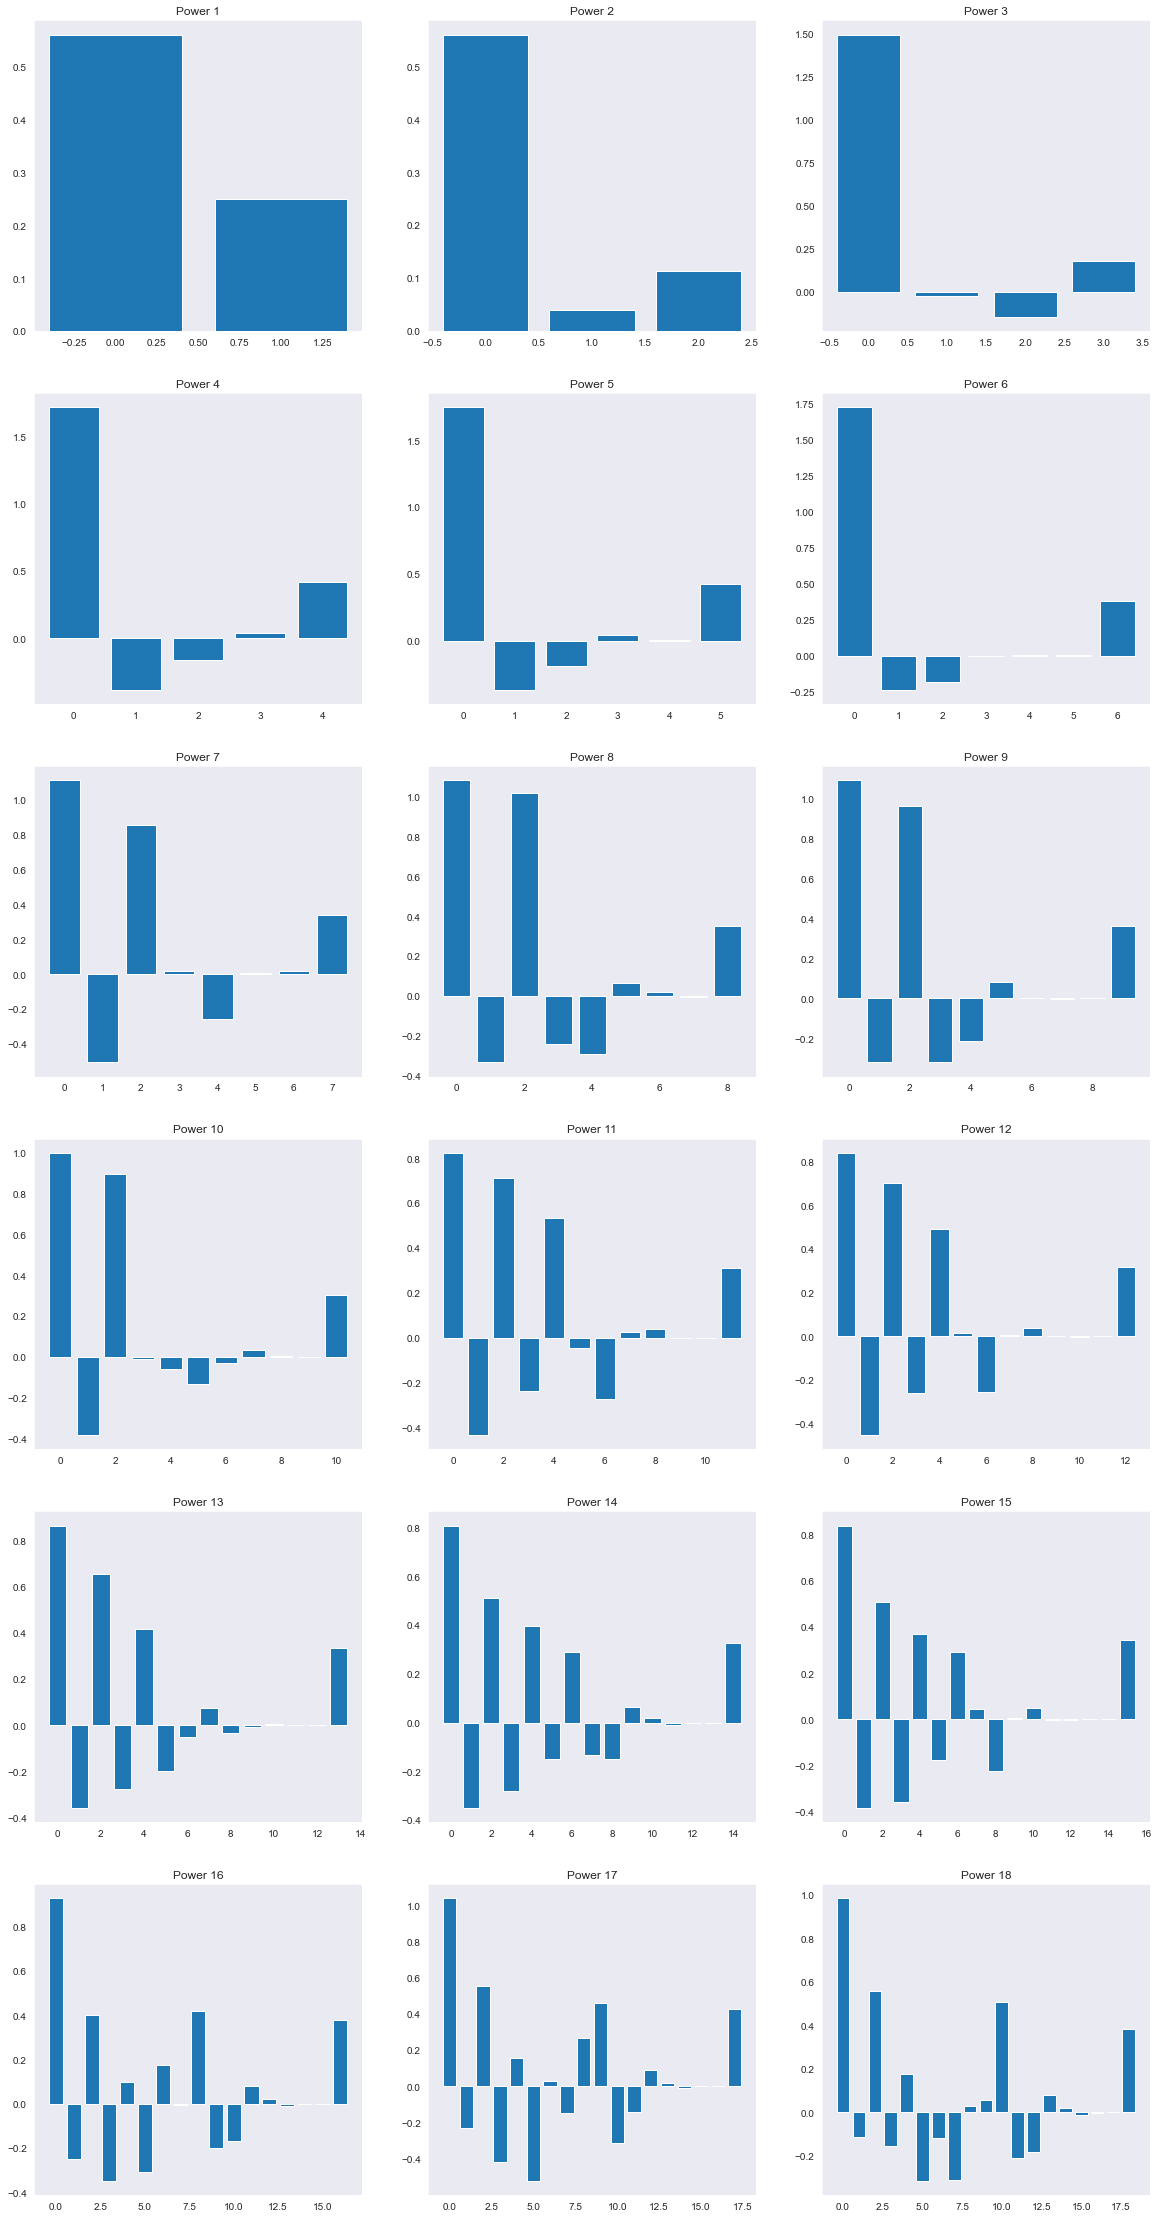

In [40]:
plt.figure(figsize=(20,40))
for p, w in enumerate(w_list):
    w = w.reshape(w.shape[0])
    
    plt.subplot(6,3,p+1)
    plt.bar(range(len(w)), w)
    plt.title("Power "+str(p+1))
plt.show()